In [32]:
## import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [33]:
loan_data = pd.read_csv("loan.csv")
print(loan_data.shape)
loan_data.head()

(39717, 111)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [34]:
# Drop those rows which has active loan account, as they won't help in deciding defaulter
curr_idx = loan_data.loc[loan_data.loc[:, "loan_status"] == "Current"].index
loan_data.drop(index=curr_idx, inplace=True)

In [35]:
# Remove columns with all null values
loan_data.dropna(axis = 1, how = 'all', inplace = True)
loan_data.shape

(38577, 56)

In [36]:
# Remove colums with single values
loan_data.drop(columns=loan_data.columns[loan_data.nunique() <= 1], inplace=True)
print(loan_data.shape)

(38577, 45)


In [37]:
# Make bin for emp_length
loan_data["emp_length"] = loan_data["emp_length"].str.replace("years", "")
loan_data["emp_length"] = loan_data["emp_length"].str.replace("year", "")
loan_data["emp_length"] = loan_data["emp_length"].str.replace("<", "")
loan_data["emp_length"] = loan_data["emp_length"].str.replace("+", "")
loan_data["emp_length"] = pd.to_numeric(loan_data["emp_length"])
loan_data["emp_length"].describe()

count    37544.000000
mean         5.061048
std          3.401750
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         10.000000
Name: emp_length, dtype: float64

In [38]:
# Create numeric data for int_rate & revol_util
for val in ("int_rate", "revol_util"):
    loan_data[val] = pd.to_numeric(loan_data[val].str.replace("%", ""))

In [39]:
loan_data["verification_status"].value_counts()
# Mark verified 1 if verification_status is not "Not Verified"
loan_data.loc[loan_data["verification_status"] == "Not Verified", "verified"] = 0
loan_data.loc[loan_data["verification_status"] == "Verified", "verified"] = 1
loan_data.loc[loan_data["verification_status"] == "Source Verified", "verified"] = 2
loan_data.drop(columns=["verification_status"], inplace=True)
loan_data["verified"].value_counts()

0.0    16694
1.0    12206
2.0     9677
Name: verified, dtype: int64

In [40]:
# Marking whether term is 36 or not.
loan_data["term_in_months"] = pd.to_numeric(loan_data["term"].str.replace("months", ""))
loan_data.loc[loan_data["term_in_months"] == 36, "term_36_not60"] = 1
loan_data.loc[loan_data["term_in_months"] == 60, "term_36_not60"] = 0
loan_data.drop(columns=["term", "term_in_months"], inplace=True)
print(loan_data["term_36_not60"].value_counts())

1.0    29096
0.0     9481
Name: term_36_not60, dtype: int64


In [41]:
# Marking whether loan is paid or not
loan_data.loc[loan_data["loan_status"] == "Charged Off", "loan_paid"] = 0
loan_data.loc[loan_data["loan_status"] == "Fully Paid", "loan_paid"] = 1
loan_data.drop(columns=["loan_status"], inplace=True)
loan_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'url', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'pub_rec_bankruptcies', 'verified',
       'term_36_not60', 'loan_paid'],
      dtype='object')

In [42]:
loan_data.isnull().sum()


id                             0
member_id                      0
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
int_rate                       0
installment                    0
grade                          0
sub_grade                      0
emp_title                   2386
emp_length                  1033
home_ownership                 0
annual_inc                     0
issue_d                        0
url                            0
desc                       12527
purpose                        0
title                         11
zip_code                       0
addr_state                     0
dti                            0
delinq_2yrs                    0
earliest_cr_line               0
inq_last_6mths                 0
mths_since_last_delinq     24905
mths_since_last_record     35837
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                    50
total_acc 

In [43]:
# pub_rec & pub_rec_bankruptcies both are closely connected.
print((loan_data["pub_rec"] - loan_data["pub_rec_bankruptcies"]).value_counts())
# Most of the value present in pub_rec is 0.
print(loan_data["pub_rec"].value_counts())

# Thus pub_rec & pub_rec_bankruptcies both can be dropped.

0.0    37472
1.0      357
2.0       42
3.0        7
4.0        2
dtype: int64
0    36507
1     2013
2       48
3        7
4        2
Name: pub_rec, dtype: int64


## Variables having no association
##### id , member_id, emp_title, url, desc, zip_code, addr_state

## loan_paid        => IDENTIFIER

## Imp Variables for applicant
### Variables needs bucketting
##### loan_amnt, int_rate, installment, annual_inc, credit_age (issue_d - earliest_cr_line), dti, open_acc, (total_acc - open_acc)
### Variables already categorized
##### term_36_not60, grade, emp_length(1033 null values), home_ownership, verified, purpose, inq_last_6mths
### Imp Variables for applicant but can be dropped
##### sub_grade (focussing on grade); title(purpose is sufficient); ; pub_rec, pub_rec_bankruptcies , ( pub_rec & pub_rec_bankruptcies both are closely connected and mostly set to 0);   mths_since_last_record (35837 null values)


## Customer Behaviour Variable (Post Loan Approval), thus not present while applying loan. Thus they can not help us in predicting for credit approval or rejection.
##### funded_amnt, funded_amnt_inv, revol_bal, revol_util, delinq_2yrs, mths_since_last_delinq, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d 

In [44]:
# Dropping columns mentioned above
loan = loan_data.drop(columns=["id", "member_id", "funded_amnt", "funded_amnt_inv", "emp_title", "url", "desc",
                               "zip_code", "addr_state", "revol_bal", "revol_util", "delinq_2yrs",
                               "mths_since_last_delinq", "mths_since_last_record", "pub_rec", "sub_grade",
                               "title","total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int",
                               "total_rec_late_fee", "recoveries", "collection_recovery_fee", "pub_rec_bankruptcies",
                               "last_pymnt_d", "last_pymnt_amnt", "last_credit_pull_d",])
loan.shape

(38577, 17)

In [45]:
loan["closed_acc"] = loan["total_acc"] - loan["open_acc"]
loan.drop(columns=["total_acc"], inplace=True)
loan.columns

Index(['loan_amnt', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'issue_d', 'purpose', 'dti',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'verified',
       'term_36_not60', 'loan_paid', 'closed_acc'],
      dtype='object')

In [46]:
for attr in ("earliest_cr_line", "issue_d"):
    loan[f"{attr}_year"] = loan[attr].apply(lambda x: 
        (1900+int(x.split('-')[1]) if int(x.split('-')[1])>50 else (2000+int(x.split('-')[1]))))
    loan[f"{attr}_month"] = loan[attr].apply(lambda x: x.split('-')[0])

loan["credit_age"] = pd.to_datetime(loan["issue_d_year"].astype(str) + '/' + loan["issue_d_month"] + '/' + '01').dt.to_period('M').astype(int) - \
    pd.to_datetime(loan["earliest_cr_line_year"].astype(str) + '/' + loan["earliest_cr_line_month"] + '/' + '01').dt.to_period('M').astype(int)
loan.drop(columns=["earliest_cr_line", "earliest_cr_line_year", "earliest_cr_line_month", "issue_d", "issue_d_year", "issue_d_month"], inplace=True)
loan.columns

Index(['loan_amnt', 'int_rate', 'installment', 'grade', 'emp_length',
       'home_ownership', 'annual_inc', 'purpose', 'dti', 'inq_last_6mths',
       'open_acc', 'verified', 'term_36_not60', 'loan_paid', 'closed_acc',
       'credit_age'],
      dtype='object')

In [47]:
# Functions to create different bins for a column
def getCutInfo(title: str, jump: float) -> dict:
    percentile = [ round(i, 2) for i in np.arange(0, 1, jump) ]
    percentile.append(1.0)
    binLabel = [ f'{title}_{str(i)}' for i in range(1, len(percentile))]
    return {"label" : binLabel, "percentileInfo" : percentile}

def bucketting(df: pd.DataFrame, title: str, jump: float, cutDict: dict) -> None:
    if title not in df.columns:
        print(f"{title} not present in provided data-frame")
        return
    cutInfo = getCutInfo(title, jump)
    qcutOut = pd.qcut(df[title], q=cutInfo['percentileInfo'], labels=cutInfo['label'], retbins=True)
    df[f'{title}_level'] = qcutOut[0]
    cutDict[title] = qcutOut[1]
    df.drop(columns=[title], inplace=True)

In [48]:
# Creating bins for loan_amnt, int_rate, installment, annual_inc
cutRange = {}
for title in ("loan_amnt", "int_rate", "installment", "annual_inc", "dti", "credit_age", "closed_acc", "open_acc"):
    bucketting(loan, title, 0.1, cutRange)
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   grade              38577 non-null  object  
 1   emp_length         37544 non-null  float64 
 2   home_ownership     38577 non-null  object  
 3   purpose            38577 non-null  object  
 4   inq_last_6mths     38577 non-null  int64   
 5   verified           38577 non-null  float64 
 6   term_36_not60      38577 non-null  float64 
 7   loan_paid          38577 non-null  float64 
 8   loan_amnt_level    38577 non-null  category
 9   int_rate_level     38577 non-null  category
 10  installment_level  38577 non-null  category
 11  annual_inc_level   38577 non-null  category
 12  dti_level          38577 non-null  category
 13  credit_age_level   38577 non-null  category
 14  closed_acc_level   38577 non-null  category
 15  open_acc_level     38577 non-null  category
dtypes: c

# Univariate & Segmented Univariate Analysis

Too less data for G under grade
Too less data for NONE under home_ownership
Too less data for OTHER under home_ownership
Too less data for renewable_energy under purpose
Too less data for 4 under inq_last_6mths
Too less data for 5 under inq_last_6mths
Too less data for 6 under inq_last_6mths
Too less data for 7 under inq_last_6mths
Too less data for 8 under inq_last_6mths


<Figure size 432x288 with 0 Axes>

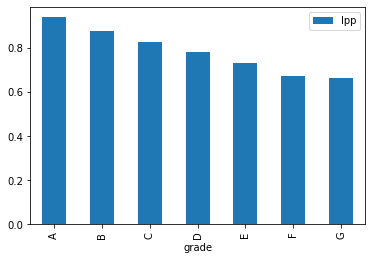

<Figure size 432x288 with 0 Axes>

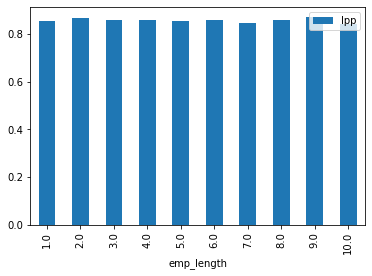

<Figure size 432x288 with 0 Axes>

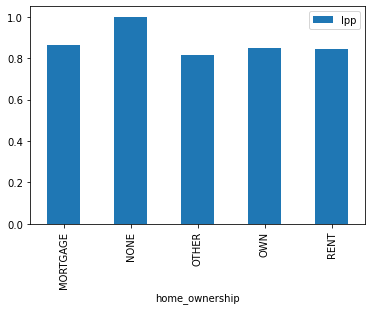

<Figure size 432x288 with 0 Axes>

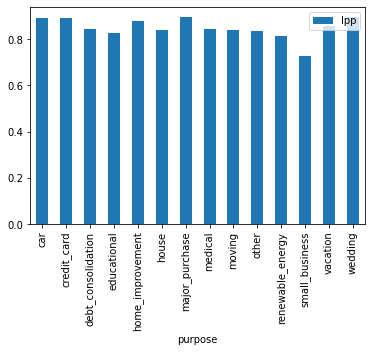

<Figure size 432x288 with 0 Axes>

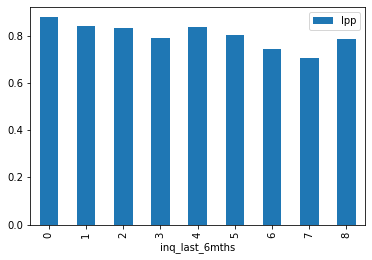

<Figure size 432x288 with 0 Axes>

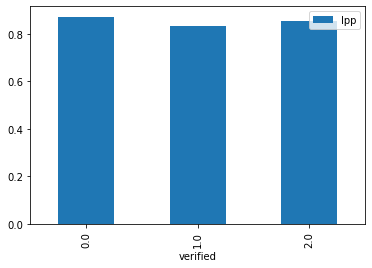

<Figure size 432x288 with 0 Axes>

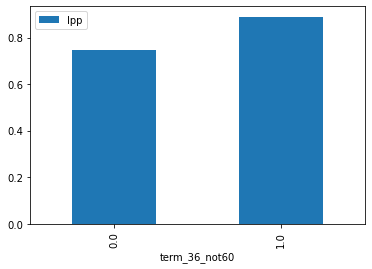

<Figure size 432x288 with 0 Axes>

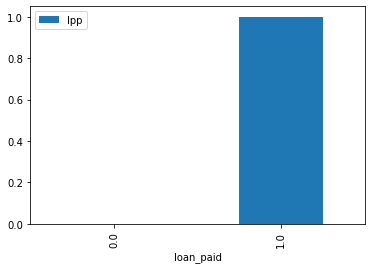

<Figure size 432x288 with 0 Axes>

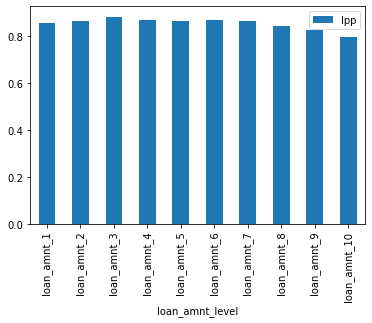

<Figure size 432x288 with 0 Axes>

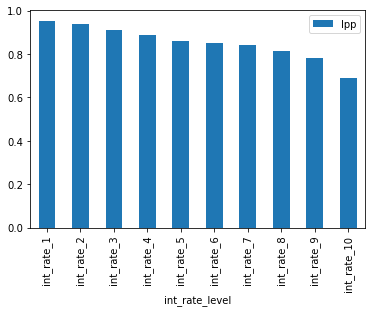

<Figure size 432x288 with 0 Axes>

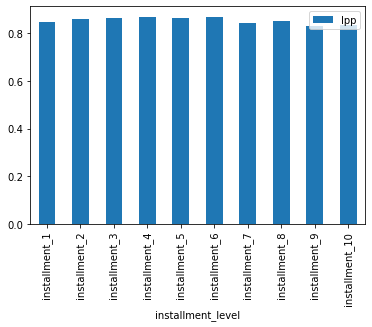

<Figure size 432x288 with 0 Axes>

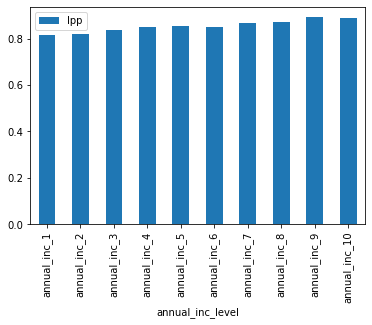

<Figure size 432x288 with 0 Axes>

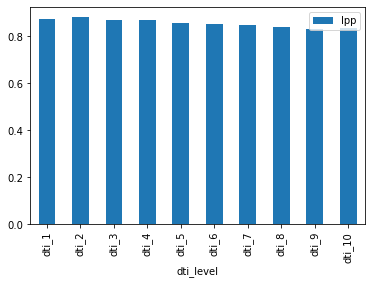

<Figure size 432x288 with 0 Axes>

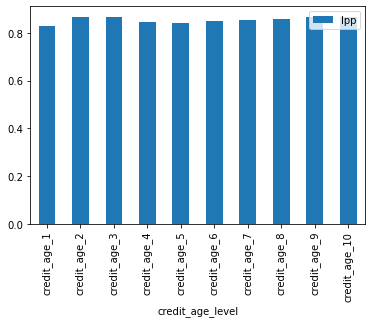

<Figure size 432x288 with 0 Axes>

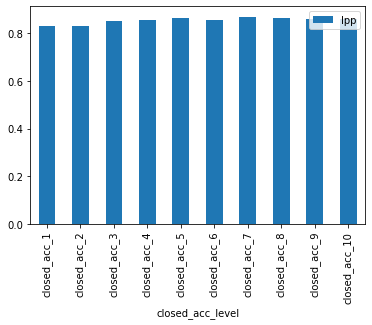

<Figure size 432x288 with 0 Axes>

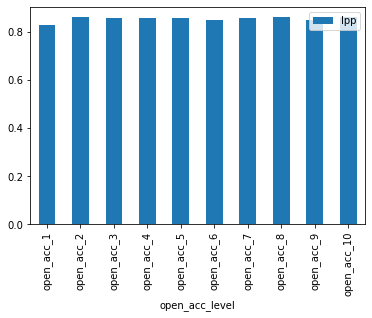

In [49]:
'''
 0   grade              38577 non-null  object  
 1   emp_length         37544 non-null  float64 
 2   home_ownership     38577 non-null  object  
 3   purpose            38577 non-null  object  
 4   verified           38577 non-null  float64 
 5   term_36_not60      38577 non-null  float64 
 6   loan_paid          38577 non-null  float64 
 7   loan_amnt_level    38577 non-null  category
 8   int_rate_level     38577 non-null  category
 9   installment_level  38577 non-null  category
 10  annual_inc_level   38577 non-null  category
 11  dti_level          38577 non-null  category
 12  credit_age_level   38577 non-null  category
'''

for attr in loan.columns:
    d = dict()
    allVals = loan[attr].value_counts().index.values
    if type(allVals[0]) == str and (allVals[0].split('_')[-1]).isdigit():
        sortedAllVals = sorted(allVals, key=lambda d: int(d.split('_')[-1]))
    else:
        sortedAllVals = sorted(allVals)
    for val in sortedAllVals:
        if len(loan.loc[loan[attr] == val]) < len(loan)/(10*len(loan[attr].value_counts().index.values)):
            print(f"Too less data for {val} under {attr}")
        d[val] = len(loan.loc[(loan[attr] == val) & (loan["loan_paid"] == 1)])/len(loan.loc[loan[attr] == val])
    plt.figure()
    (pd.DataFrame({attr:d.keys(), "lpp"  : d.values()})).plot.bar(x=attr, y="lpp")

In [50]:
cutRange

{'loan_amnt': array([  500.,  3090.,  5000.,  6000.,  7750.,  9600., 11200., 14000.,
        16000., 21600., 35000.]),
 'int_rate': array([ 5.42,  7.14,  7.9 ,  9.99, 10.99, 11.71, 12.84, 13.8 , 15.21,
        16.82, 24.4 ]),
 'installment': array([  15.69 ,   98.99 ,  149.922,  186.06 ,  228.71 ,  277.86 ,
         327.96 ,  386.974,  480.33 ,  620.9  , 1305.19 ]),
 'annual_inc': array([4.000000e+03, 3.000000e+04, 3.719616e+04, 4.450000e+04,
        5.000400e+04, 5.886800e+04, 6.500400e+04, 7.500000e+04,
        9.000000e+04, 1.150000e+05, 6.000000e+06]),
 'dti': array([ 0.  ,  4.06,  6.91,  9.24, 11.35, 13.37, 15.31, 17.43, 19.71,
        22.29, 29.99]),
 'credit_age': array([-475.,   72.,   97.,  119.,  134.,  150.,  168.,  191.,  221.,
         274.,  684.]),
 'closed_acc': array([-6.,  3.,  5.,  7.,  9., 11., 14., 16., 20., 25., 75.]),
 'open_acc': array([ 2.,  4.,  6.,  7.,  8.,  9., 10., 11., 13., 15., 44.])}

# Bivariate Analysis

In [51]:
loan.isnull().sum()

grade                   0
emp_length           1033
home_ownership          0
purpose                 0
inq_last_6mths          0
verified                0
term_36_not60           0
loan_paid               0
loan_amnt_level         0
int_rate_level          0
installment_level       0
annual_inc_level        0
dti_level               0
credit_age_level        0
closed_acc_level        0
open_acc_level          0
dtype: int64

In [52]:
print((loan.loc[loan["loan_paid"] == 1, "emp_length"]).describe())
print((loan.loc[loan["loan_paid"] == 0, "emp_length"]).describe())

count    32145.000000
mean         5.037829
std          3.393861
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         10.000000
Name: emp_length, dtype: float64
count    5399.000000
mean        5.199296
std         3.445429
min         1.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        10.000000
Name: emp_length, dtype: float64


In [53]:
loan.loc[(loan["loan_paid"] == 1) & (loan["emp_length"].isna()), "emp_length"] = 4
loan.loc[(loan["loan_paid"] == 0) & (loan["emp_length"].isna()), "emp_length"] = 5

In [54]:
loan.isnull().sum()

grade                0
emp_length           0
home_ownership       0
purpose              0
inq_last_6mths       0
verified             0
term_36_not60        0
loan_paid            0
loan_amnt_level      0
int_rate_level       0
installment_level    0
annual_inc_level     0
dti_level            0
credit_age_level     0
closed_acc_level     0
open_acc_level       0
dtype: int64

Creating bins for some numerical variable to make them categorical

In [55]:
#creating bins for int_rate,open_acc,revol_util,total_acc
loan_data['int_rate_groups'] = pd.cut(loan_data['int_rate'], bins=5,precision =0,labels=['5%-9%','9%-13%','13%-17%','17%-21%','21%-24%'])
loan_data['open_acc_groups'] = pd.cut(loan_data['open_acc'],bins = 5,precision =0,labels=['2-10','10-19','19-27','27-36','36-44'])
loan_data['revol_util_groups'] = pd.cut(loan_data['revol_util'], bins=5,precision =0,labels=['0-20','20-40','40-60','60-80','80-100'])
loan_data['total_acc_groups'] = pd.cut(loan_data['total_acc'], bins=5,precision =0,labels=['2-20','20-37','37-55','55-74','74-90'])
loan_data['annual_inc_groups'] = pd.cut(loan_data['annual_inc'], bins=5,precision =0,labels =['3k-31k','31k-58k','58k-85k','85k-112k','112k-140k'])

In [56]:
# Viewing new bins created
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_title,...,last_credit_pull_d,pub_rec_bankruptcies,verified,term_36_not60,loan_paid,int_rate_groups,open_acc_groups,revol_util_groups,total_acc_groups,annual_inc_groups
0,1077501,1296599,5000,5000,4975.0,10.65,162.87,B,B2,NaN,...,May-16,0.0,1.0,1.0,1.0,9%-13%,2-10,80-100,2-20,3k-31k
1,1077430,1314167,2500,2500,2500.0,15.27,59.83,C,C4,Ryder,...,Sep-13,0.0,2.0,0.0,0.0,13%-17%,2-10,0-20,2-20,3k-31k
2,1077175,1313524,2400,2400,2400.0,15.96,84.33,C,C5,NaN,...,May-16,0.0,0.0,1.0,1.0,13%-17%,2-10,80-100,2-20,3k-31k
3,1076863,1277178,10000,10000,10000.0,13.49,339.31,C,C1,AIR RESOURCES BOARD,...,Apr-16,0.0,2.0,1.0,1.0,13%-17%,2-10,20-40,20-37,3k-31k
5,1075269,1311441,5000,5000,5000.0,7.90,156.46,A,A4,Veolia Transportaton,...,Jan-16,0.0,2.0,1.0,1.0,5%-9%,2-10,20-40,2-20,3k-31k


Analyzing interest rate wrt the interest rate bins created

In [57]:
loan_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'url', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'pub_rec_bankruptcies', 'verified',
       'term_36_not60', 'loan_paid', 'int_rate_groups', 'open_acc_groups',
       'revol_util_groups', 'total_acc_groups', 'annual_inc_groups'],
      dtype='object')

Analyzing by issued month and year

In [59]:
## Extracting month and year
df_month_year = loan_data['issue_d'].str.partition("-", True)     
loan_data['issue_month']=df_month_year[0]                       
loan_data['issue_year']='20' + df_month_year[2]

In [63]:
print(loan_data.loan_paid)

0        1.0
1        0.0
2        1.0
3        1.0
5        1.0
        ... 
39712    1.0
39713    1.0
39714    1.0
39715    1.0
39716    1.0
Name: loan_paid, Length: 38577, dtype: float64


<AxesSubplot:xlabel='issue_year', ylabel='count'>

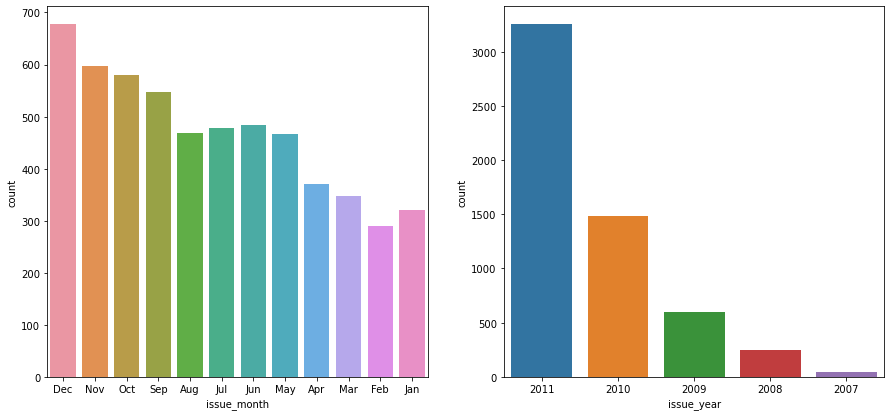

In [65]:
plt.figure(figsize=(15,15))
plt.subplot(221)
sns.countplot(x='issue_month', data=loan_data[loan_data['loan_paid']==0])
plt.subplot(222)
sns.countplot(x='issue_year', data=loan_data[loan_data['loan_paid']==0])

Maximum number of defaults occured when the loan was sanctioned/issued in Dec. Loan issued in the year 2011 were also as compared to other years
Analyzing installment,dti, loan_amnt

In [66]:
loan_data['installment_groups'] = pd.cut(loan_data['installment'], bins=10,precision =0,labels=['14-145','145-274','274-403','403-531','531-660','660-789','789-918','918-1047','1047-1176','1176-1305'])
loan_data['funded_amnt_inv_group'] = pd.cut(loan_data['funded_amnt_inv'], bins=7,labels=['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k','30k-35k']) ## bin is starting from -35?
loan_data['loan_amnt_groups'] = pd.cut(loan_data['loan_amnt'], bins=7,precision =0,labels=['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k','30k-35k'])
loan_data['dti_groups'] = pd.cut(loan_data['dti'], bins=5,precision =0,labels=['0-6','6-12','12-18','18-24','24-30'])

<AxesSubplot:xlabel='funded_amnt_inv_group', ylabel='count'>

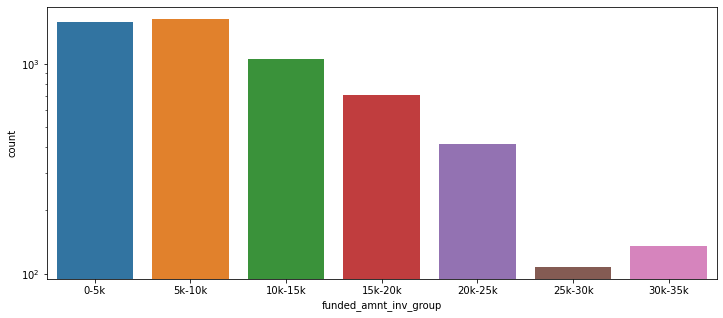

In [67]:
fig,ax = plt.subplots(figsize = (12,5))
ax.set_yscale('log')
sns.countplot(x='funded_amnt_inv_group', data=loan_data[loan_data['loan_paid']==0])

<AxesSubplot:xlabel='dti_groups', ylabel='count'>

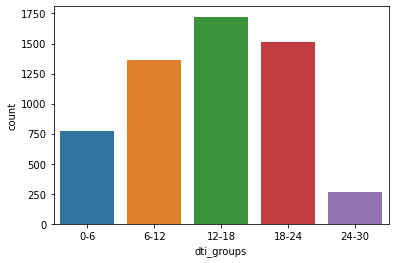

In [68]:
sns.countplot(x='dti_groups', data=loan_data[loan_data['loan_paid']==0])

<AxesSubplot:xlabel='installment_groups', ylabel='count'>

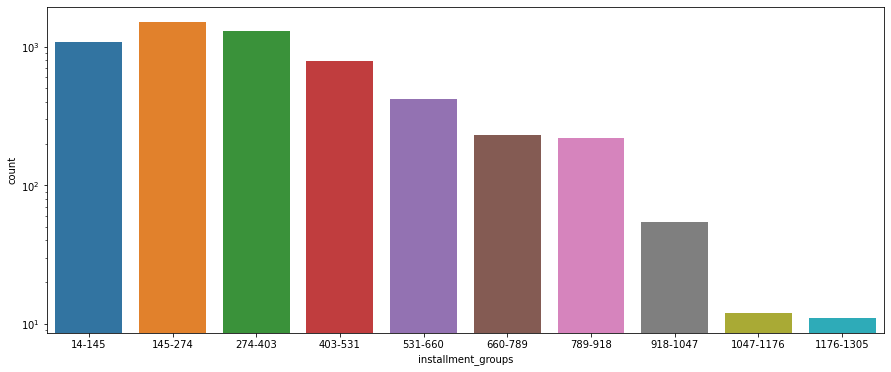

In [69]:
fig,ax = plt.subplots(figsize = (15,6))
ax.set_yscale('log')
sns.countplot(x='installment_groups', data=loan_data[loan_data['loan_paid']==0])

# Observations

##### The above analysis with respect to the charged off loans for each variable suggests the following. There is a more probability of defaulting when :-
#### Applicants having house_ownership as 'RENT'
#### Applicants who use the loan to clear other debts
#### Applicants who receive interest at the rate of 13-17%
#### Applicants who have an income of range 31201 - 58402
#### Applicants who have 20-37 open_acc
#### Applicants with employement length of 10
#### When funded amount by investor is between 5000-10000
#### Loan amount is between 5429 - 10357
#### Dti is between 12-18
#### When monthly installments are between 145-274
#### Term of 36 months
#### When the loan status is Not verified
#### When the no of enquiries in last 6 months is 0
#### When the number of derogatory public records is 0
#### When the purpose is 'debt_consolidation'
#### Grade is 'B'
#### And a total grade of 'B5' level.
#### Also there is a very interesting observation from the date issued. The late months of an year indicated the high possibility of defaulting.
#### The high number of loan defaults in 2011 could be due to the financial crisis in USA (Assuming the data is of US origin)

#### Analysing annual income with other columns for more insights
#### 1.Annual income vs loan purpose

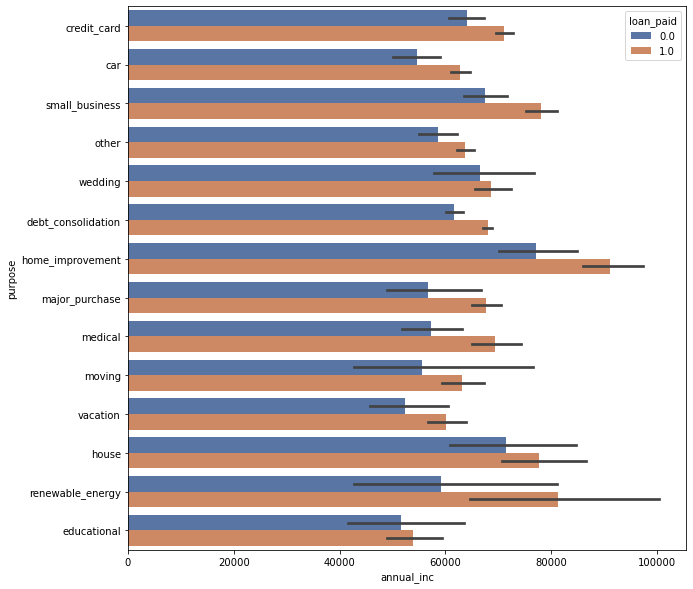

In [71]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='annual_inc', y='purpose', hue ='loan_paid',palette="deep")
plt.show()

## Though the number of loans applied and defaulted are the highest in number for "debt_consolation", the annual income of those who applied isn't the highest.
Applicants with higher salary mostly applied loans for "home_improvment", "house", "renewable_energy" and "small_businesses"
2.Annual income vs home ownership

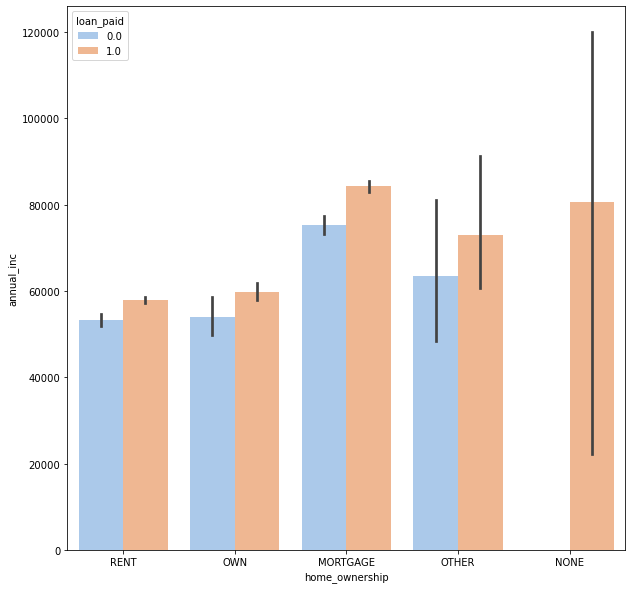

In [73]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='home_ownership', y='annual_inc', hue ='loan_paid',palette="pastel")
plt.show()

Annual Income vs Loan amount

<AxesSubplot:xlabel='annual_inc_groups', ylabel='loan_amnt'>

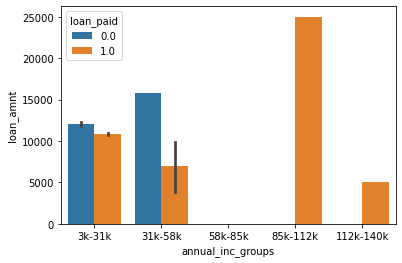

In [74]:
sns.barplot(x = "annual_inc_groups", y = "loan_amnt", hue = 'loan_paid', data = loan_data)

### Analysing loan_amount with other columns for more insights
1.Loan Amount vs Interest Rate

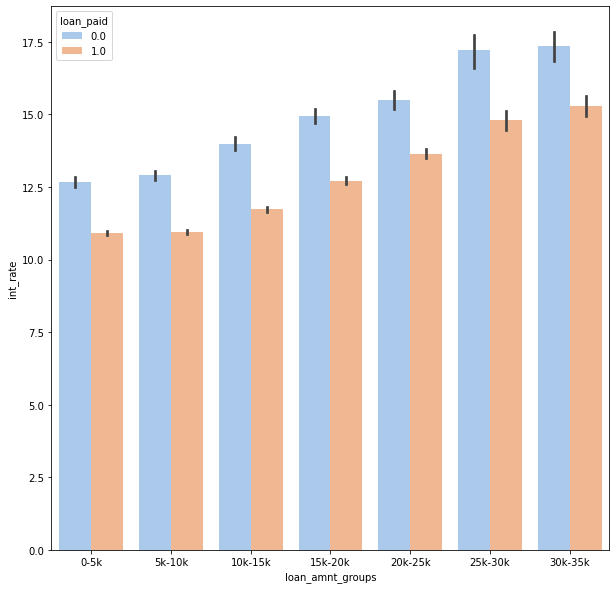

In [76]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='loan_amnt_groups', y='int_rate', hue ='loan_paid',palette="pastel")
plt.show()

2.Loan vs Loan purpose

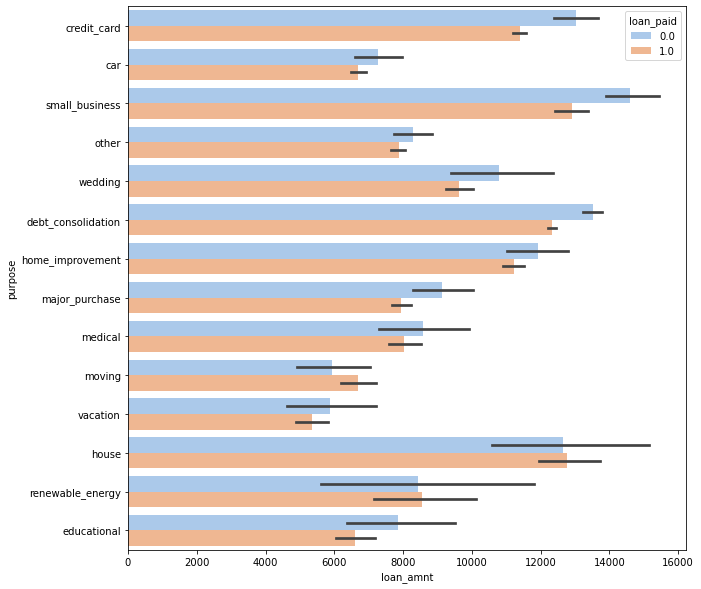

In [78]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='loan_amnt', y='purpose', hue ='loan_paid',palette="pastel")
plt.show()

## 3.Loan vs House Ownership

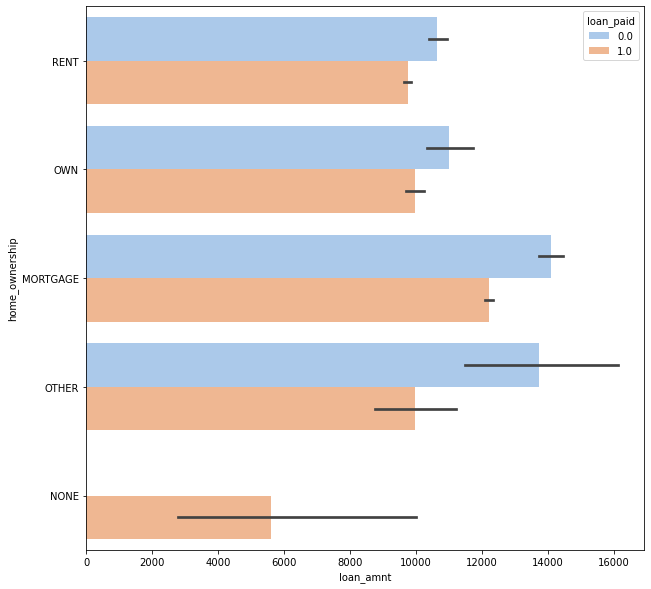

In [80]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='loan_amnt', y='home_ownership', hue ='loan_paid',palette="pastel")
plt.show()

### 4.Loan amount vs month issued and year issued

<AxesSubplot:xlabel='issue_year', ylabel='loan_amnt'>

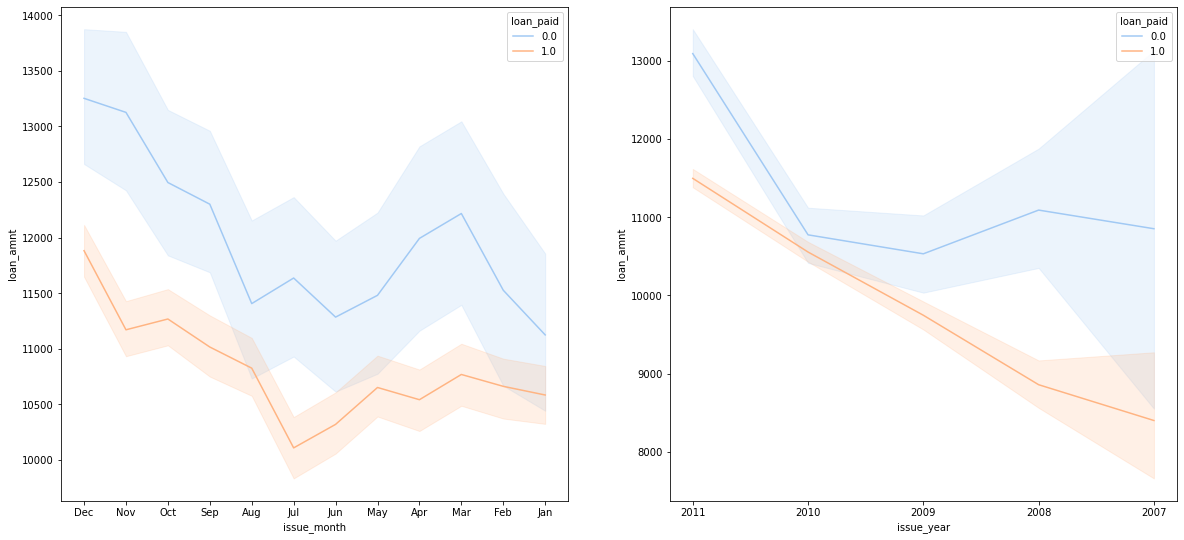

In [82]:
plt.figure(figsize=(20,20))
plt.subplot(221)
sns.lineplot(data =loan_data,y='loan_amnt', x='issue_month', hue ='loan_paid',palette="pastel")
plt.subplot(222)
sns.lineplot(data =loan_data,y='loan_amnt', x='issue_year', hue ='loan_paid',palette="pastel")

## 5.Loan amount vs Grade

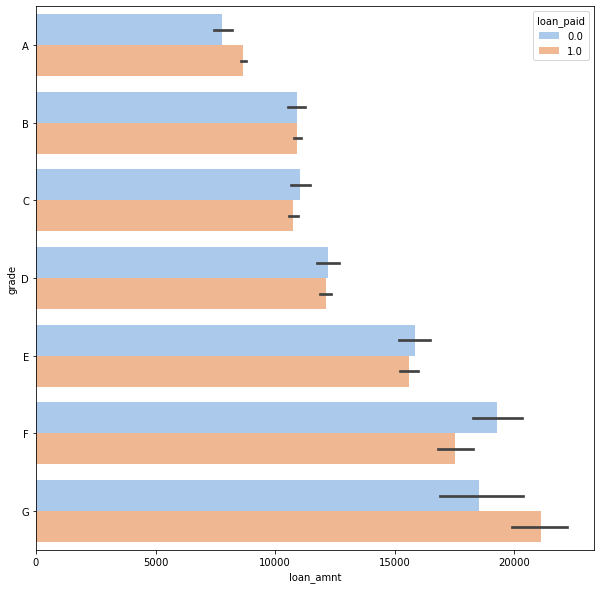

In [83]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='loan_amnt', y='grade', hue ='loan_paid',palette="pastel", order=['A','B','C','D','E','F','G'])
plt.show()

<AxesSubplot:xlabel='emp_length', ylabel='loan_amnt'>

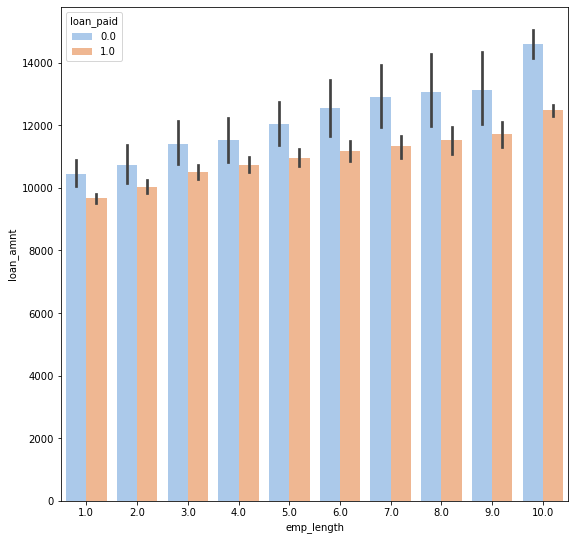

In [85]:
plt.figure(figsize=(20,20))
plt.subplot(221)
sns.barplot(data =loan_data,y='loan_amnt', x='emp_length', hue ='loan_paid',palette="pastel")

## Employees with longer working history got the loan approved for a higher amount.

### Looking at the verification status data, verified loan applications tend to have higher loan amount. Which might indicate that the firms are first verifying the loans with higher values.

#### grade vs interest rate

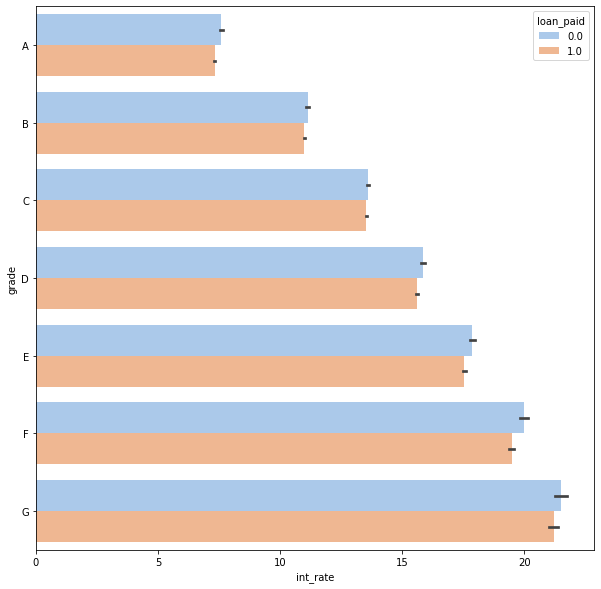

In [86]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='int_rate', y='grade', hue ='loan_paid',palette="pastel", order=['A','B','C','D','E','F','G'])
plt.show()

<Figure size 432x288 with 0 Axes>

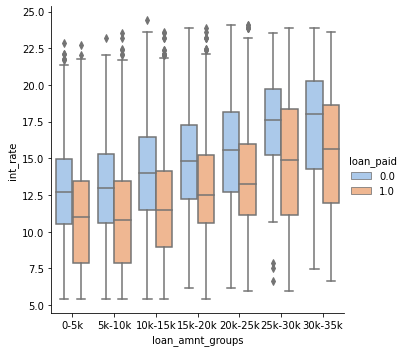

In [87]:
# fig,ax = plt.subplots(figsize = (15,6))
plt.tight_layout()
sns.catplot(data =loan_data,y ='int_rate', x ='loan_amnt_groups', hue ='loan_paid',palette="pastel",kind = 'box')

### The interest rate for charged off loans is pretty high than that of fully paid loans in all the loan_amount groups.
This can be a pretty strong driving factor for loan defaulting.

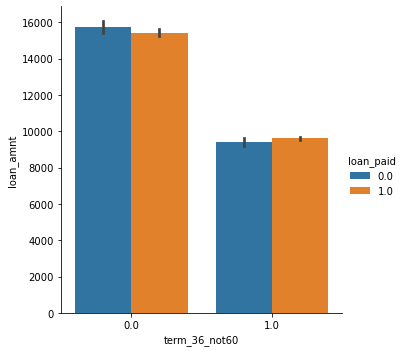

In [89]:
sns.catplot(x = 'term_36_not60', y = 'loan_amnt', data = loan_data,hue = 'loan_paid', kind = 'bar')

## Applicants who applied and defaulted have no significant difference in loan_amounts.


### Which means that applicants applying for long term has applied for more loan.

## Observations

#### The above analysis with respect to the charged off loans. There is a more probability of defaulting when :
#### Applicants taking loan for 'home improvement' and have income of 60k -70k
#### Applicants whose home ownership is 'MORTGAGE and have income of 60-70k
#### Applicants who receive interest at the rate of 21-24% and have an income of 70k-80k
#### Applicants who have taken a loan in the range 30k - 35k and are charged interest rate of 15-17.5 %
#### Applicants who have taken a loan for small business and the loan amount is greater than 14k
#### Applicants whose home ownership is 'MORTGAGE and have loan of 14-16k
#### When grade is F and loan amount is between 15k-20k
#### When employment length is 10yrs and loan amount is 12k-14k
#### When the loan is verified and loan amount is above 16k
#### For grade G and interest rate above 20%